In [1]:

!pip install transformers pandas scikit-learn torch --quiet

In [2]:
import pandas as pd
from transformers import pipeline
from sklearn.metrics import classification_report
from google.colab import files

In [6]:
# 🔹 Step 1: Upload dataset
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# 🔹 Step 2: Read Excel instead of CSV
df = pd.read_excel(filename)

print("✅ Dataset loaded:", df.shape)
print(df.head())


Saving IT_Ticket_Dataset.xlsx to IT_Ticket_Dataset (3).xlsx
✅ Dataset loaded: (1549, 2)
                                            Document    Topic_group
0  connection with icon icon dear please setup ic...       Hardware
1  work experience user work experience user hi w...         Access
2  requesting for meeting requesting meeting hi p...       Hardware
3  reset passwords for external accounts re expir...         Access
4  mail verification warning hi has got attached ...  Miscellaneous


In [7]:
# Step 2: Preprocess dataset
df = df.rename(columns={"Document": "ticket_text", "Topic_group": "true_label"})
df = df.dropna(subset=["ticket_text"])
print("✅ Dataset loaded:", df.shape)
print(df.head())

✅ Dataset loaded: (1549, 2)
                                         ticket_text     true_label
0  connection with icon icon dear please setup ic...       Hardware
1  work experience user work experience user hi w...         Access
2  requesting for meeting requesting meeting hi p...       Hardware
3  reset passwords for external accounts re expir...         Access
4  mail verification warning hi has got attached ...  Miscellaneous


In [8]:
# Step 3: Define categories
CATEGORIES = df["true_label"].unique().tolist()
print("✅ Categories:", CATEGORIES)


✅ Categories: ['Hardware', 'Access', 'Miscellaneous', 'HR Support', 'Purchase', 'Administrative rights', 'Storage', 'Internal Project']


In [9]:
#  Step 4: Load classifier
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0  # use -1 for CPU, 0 for GPU
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [10]:
# Step 5: Batch predictions
texts = df["ticket_text"].tolist()
results = classifier(texts, CATEGORIES, multi_label=False)

df["pred_zero_shot"] = [r["labels"][0] for r in results]
df["pred_top3"] = [r["labels"][:3] for r in results]

In [11]:
# 🔹 Step 6: Evaluate
print("\n✅ Evaluation Report:")
print(classification_report(df["true_label"], df["pred_zero_shot"]))


✅ Evaluation Report:
                       precision    recall  f1-score   support

               Access       0.21      0.76      0.33       273
Administrative rights       0.03      0.08      0.05        25
           HR Support       0.50      0.01      0.02       369
             Hardware       0.40      0.05      0.08       295
     Internal Project       0.05      0.01      0.02        70
        Miscellaneous       0.25      0.03      0.05       261
             Purchase       0.32      0.78      0.45       144
              Storage       0.22      0.09      0.13       112

             accuracy                           0.23      1549
            macro avg       0.25      0.23      0.14      1549
         weighted avg       0.32      0.23      0.14      1549



In [12]:
# Step 7: Save predictions
df.to_csv("ticket_predictions.csv", index=False)
print("✅ Predictions saved to ticket_predictions.csv")

✅ Predictions saved to ticket_predictions.csv


In [13]:

# Step 8: Few-shot Example (Optional)
few_shot_examples = [
    {"ticket_text": "Laptop not turning on after update", "expected_category": "Hardware"},
    {"ticket_text": "VPN access not working for remote login", "expected_category": "Access"},
    {"ticket_text": "Need to purchase additional cloud storage", "expected_category": "Purchase"},
    {"ticket_text": "HR system password reset request", "expected_category": "HR Support"},
    {"ticket_text": "Jira project setup required for new internal project", "expected_category": "Internal Project"},
]

print("\n✅ Few-shot Demo Results:")
for ex in few_shot_examples:
    result = classifier(ex["ticket_text"], CATEGORIES, multi_label=False)
    print(f"Ticket: {ex['ticket_text']}")
    print(f" Predicted: {result['labels'][0]}, Expected: {ex['expected_category']}\n")


✅ Few-shot Demo Results:
Ticket: Laptop not turning on after update
 Predicted: Access, Expected: Hardware

Ticket: VPN access not working for remote login
 Predicted: Access, Expected: Access

Ticket: Need to purchase additional cloud storage
 Predicted: Purchase, Expected: Purchase

Ticket: HR system password reset request
 Predicted: Hardware, Expected: HR Support

Ticket: Jira project setup required for new internal project
 Predicted: Internal Project, Expected: Internal Project




✅ Evaluation Report:
                       precision    recall  f1-score   support

               Access       0.21      0.76      0.33       273
Administrative rights       0.03      0.08      0.05        25
           HR Support       0.50      0.01      0.02       369
             Hardware       0.40      0.05      0.08       295
     Internal Project       0.05      0.01      0.02        70
        Miscellaneous       0.25      0.03      0.05       261
             Purchase       0.32      0.78      0.45       144
              Storage       0.22      0.09      0.13       112

             accuracy                           0.23      1549
            macro avg       0.25      0.23      0.14      1549
         weighted avg       0.32      0.23      0.14      1549



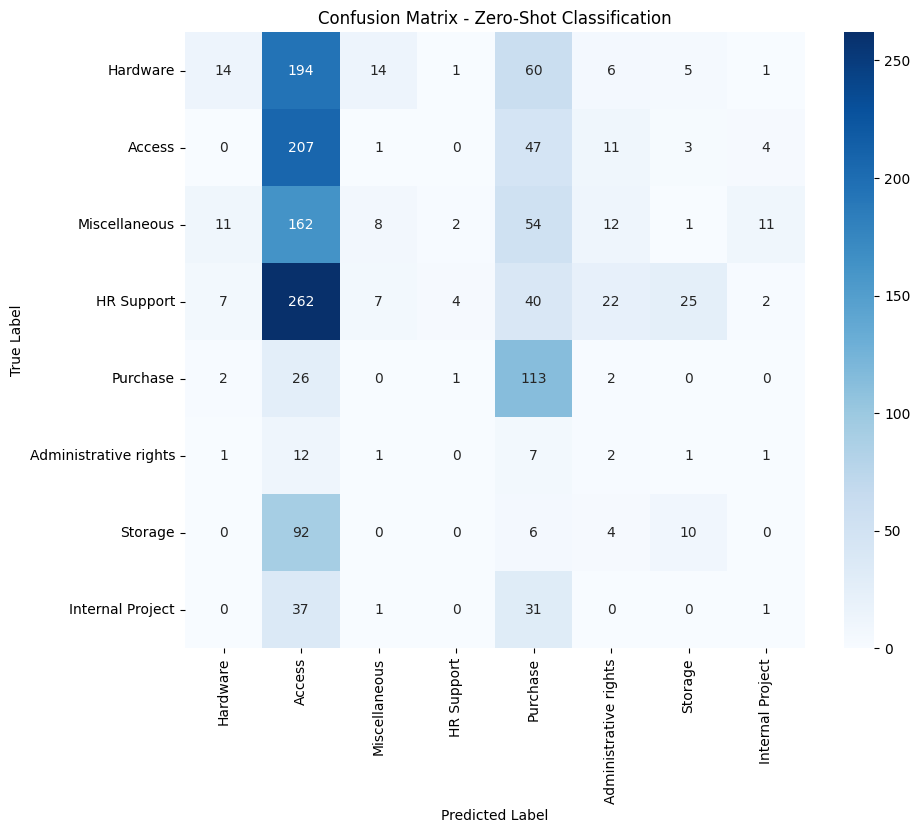

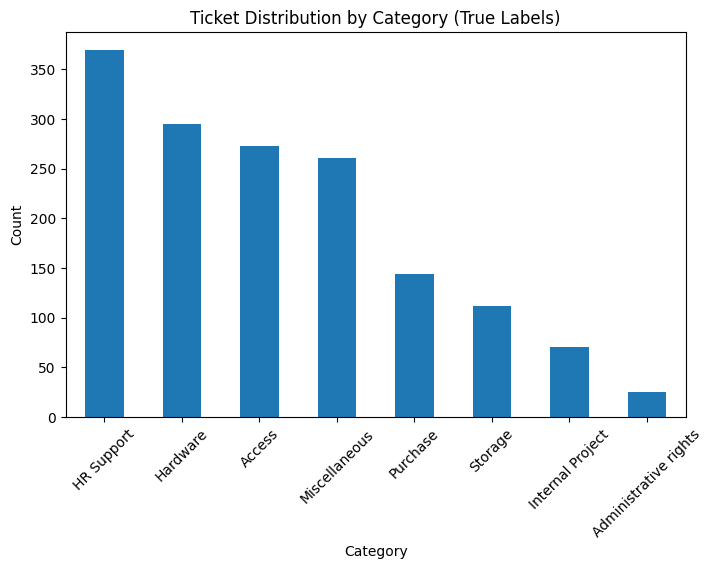

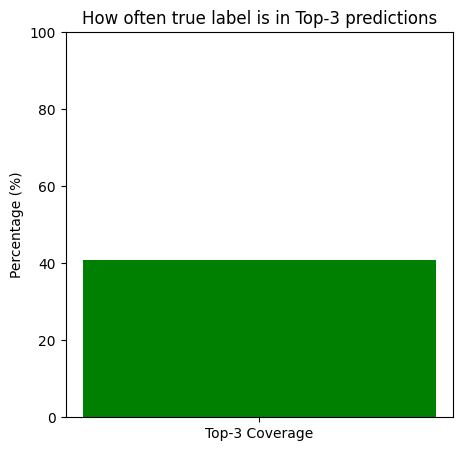

✅ Top-3 Coverage: 40.80%


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Step 9 (revised): Evaluation report
print("\n✅ Evaluation Report:")
print(classification_report(df["true_label"], df["pred_zero_shot"]))

# ✅ Step 10: Confusion Matrix
cm = confusion_matrix(df["true_label"], df["pred_zero_shot"], labels=CATEGORIES)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Zero-Shot Classification")
plt.show()

# ✅ Step 11: Category distribution (dataset balance)
plt.figure(figsize=(8, 5))
df["true_label"].value_counts().plot(kind="bar")
plt.title("Ticket Distribution by Category (True Labels)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# ✅ Step 12: Top-3 coverage plot
top3_hits = sum(df.apply(lambda row: row["true_label"] in row["pred_top3"], axis=1))
coverage = top3_hits / len(df) * 100

plt.figure(figsize=(5, 5))
plt.bar(["Top-3 Coverage"], [coverage], color="green")
plt.ylim(0, 100)
plt.ylabel("Percentage (%)")
plt.title("How often true label is in Top-3 predictions")
plt.show()

print(f"✅ Top-3 Coverage: {coverage:.2f}%")
